<a href="https://colab.research.google.com/github/lucasef27/smart-parking-finder/blob/main/Estacionamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importações

In [ ]:
import pickle as pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Leitura da base de dados

In [ ]:
!wget -O UFPR04-Sunny.zip "https://upfluxpm-my.sharepoint.com/:u:/g/personal/cleitonsg_upflux_net/EVBglqu6tTpMpYVJfUe6LYEBxh_urEfFFqXolkRPbBHE-Q?e=5fOcDn&download=1"
!unzip UFPR04-Sunny.zip

Streaming output truncated to the last 5000 lines.
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#005.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#006.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#007.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#008.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#009.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#010.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#011.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#012.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#013.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#014.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#015.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#016.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#017.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#018.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#019.jpg  
  inflating: SunnyDays/Empty/2012-12-08_09_15_04#020.jpg  
  inf

Segmentação da base em 60% treinamento e 40% entre teste e validação

In [ ]:
import tensorflow as tf

image_size = (32, 55)
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/SunnyDays", labels='inferred',shuffle = True,
    color_mode='rgb', batch_size=32, image_size=image_size, seed=123,
    validation_split=0.6, subset="training")

ds_valid_test = tf.keras.preprocessing.image_dataset_from_directory(
     "/content/SunnyDays", labels='inferred',shuffle = True,
    color_mode='rgb', batch_size=32, image_size=image_size, seed=123,
    validation_split=0.4, subset="validation")

Found 5896 files belonging to 2 classes.
Using 2359 files for training.
Found 5896 files belonging to 2 classes.
Using 2358 files for validation.


Nova separação

*   Test: 55 lotes/batch x 32 size = 1760 fotos quase 30%
*   Validação: sobram quase 19 lotes => pouco mais de 10%



In [ ]:
ds_test = ds_valid_test.take(55)
ds_val = ds_valid_test.skip(55)
print('Batches for testing -->', ds_test.cardinality())
print('Batches for validating -->', ds_val.cardinality())

import numpy as np
print('Test numero de fotos ', len(np.concatenate([i for x, i in ds_test], axis=0)) / 5896)
print('Validação numero de fotos ', len(np.concatenate([i for x, i in ds_val], axis=0)) / 5896)

Batches for testing --> tf.Tensor(55, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(19, shape=(), dtype=int64)
Test numero de fotos  0.29850746268656714
Validação numero de fotos  0.1014246947082768


Visualize algumas das fotos e suas classes

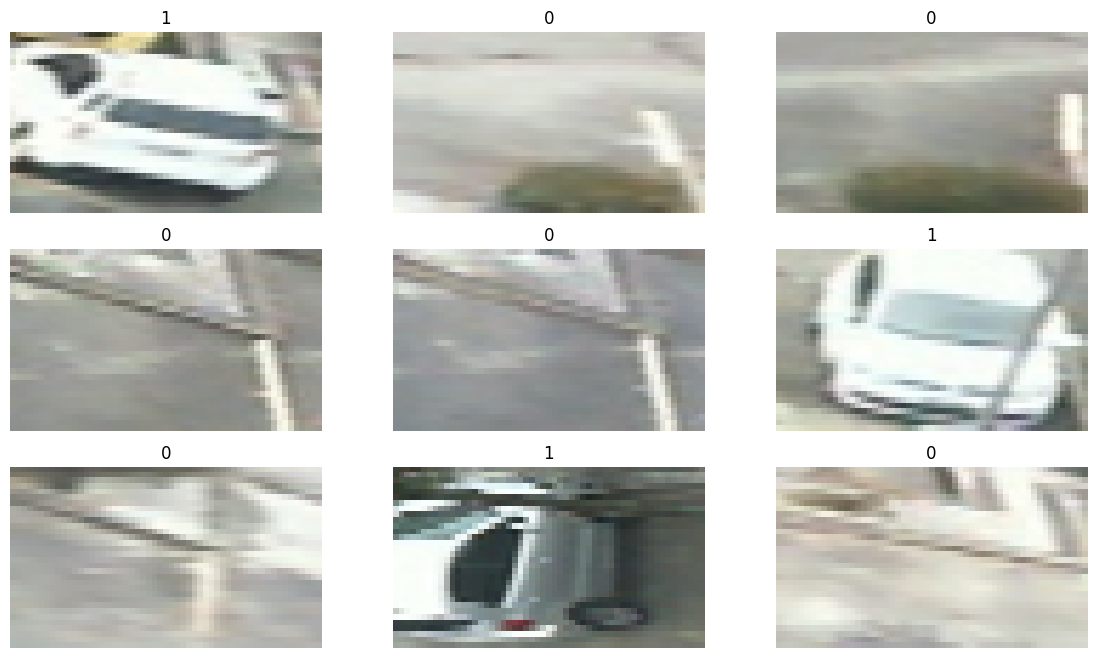

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard

cnn_model = Sequential()
#entrada da imagem em escala de cinza 32x32x1 (pré-processada)
#camada 1 - convolution 5x5 > preenchimento válido, formato de saida 28x28x6 com função
cnn_model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(32,55,3)))
#reduz (max pooling) a resolução da entrada ao longo de suas dimensões espaciais (altura)...
cnn_model.add(AveragePooling2D())
#layer  2 - convolution 5x5, saida 10x10x16
cnn_model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
#reduz para 5x5x16
cnn_model.add(AveragePooling2D())
#layer 3 - convolution 5x5x16 para saida 1x1x400
cnn_model.add(Flatten())
#layer 4 - totalmente conectada com 400 entradas e 120 saidas
cnn_model.add(Dense(units=120, activation='relu'))
#layer 5 - totalmente conectada com 120 entradas e 84 saidas
cnn_model.add(Dense(units=84, activation='relu'))
#layer 6 - totalmente conectada com 84 entradas e 43 saidas
cnn_model.add(Dense(units=43, activation='softmax'))

cnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Treine por no máximo40 épocase use para validação (validation_split=0.20)

# hist = cnn_model.fit(ds_train, epochs=40, verbose=1, validation_data=ds_val)

In [ ]:
hist = cnn_model.fit(ds_train, epochs=10, verbose=1, validation_data=ds_val)

Epoch 1/40
74/74 [==============================] - 14s 22ms/step - loss: 7.8869 - accuracy: 0.7660 - val_loss: 0.0593 - val_accuracy: 0.9799
Epoch 2/40
74/74 [==============================] - 1s 12ms/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0749 - val_accuracy: 0.9783
Epoch 3/40
74/74 [==============================] - 1s 11ms/step - loss: 0.0458 - accuracy: 0.9860 - val_loss: 0.0371 - val_accuracy: 0.9866
Epoch 4/40
74/74 [==============================] - 1s 12ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.0047 - val_accuracy: 0.9983
Epoch 5/40
74/74 [==============================] - 1s 16ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9983
Epoch 6/40
74/74 [==============================] - 1s 12ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/40
74/74 [==============================] - 1s 16ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0103 - val_accuracy: 0.9933
Epoch 8/40
7

Visualize graficamente o histórico de acurácia do treinamento e validação.Qual o número de épocas mais adequado

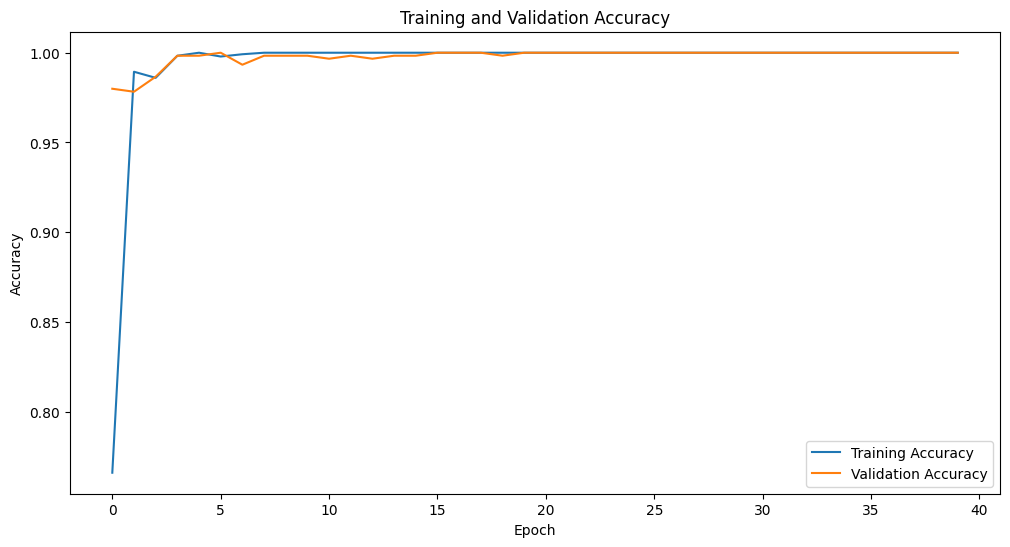

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(12, 6))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
best_epoch = np.argmax(hist.history['val_accuracy']) + 1
print('Número de épocas mais adequado:', best_epoch)

Número de épocas mais adequado: 6


Visualize a acurácia geral do modelo

In [ ]:
_, test_accuracy = cnn_model.evaluate(ds_test)
print('Acurácia geral do modelo:', test_accuracy)

55/55 [==============================] - 0s 7ms/step - loss: 0.0105 - accuracy: 0.9983
Acurácia geral do modelo: 0.9982954263687134


Faça 2 predições sobre imagens selecionadas e visualize o resultadosobre uma vaga vazia e outra ocupada

1/1 [==============================] - 0s 162ms/step


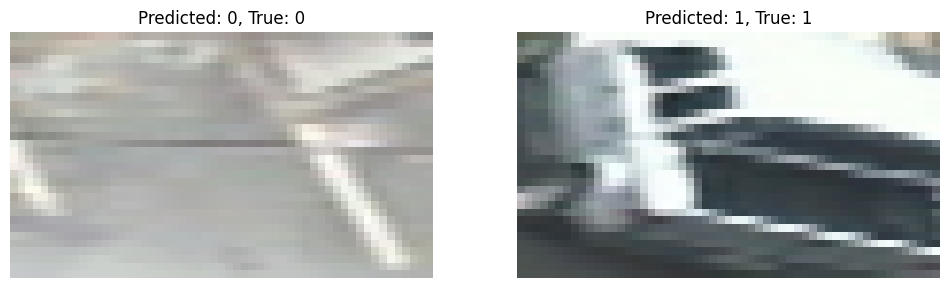

In [ ]:
images = []
labels = []

# Coleta duas amostras de imagens e rótulos para previsão
for x, y in ds_test:
    images.extend(x[:2])
    labels.extend(y[:2])
    break

# Realiza a previsão
predictions = cnn_model.predict(np.array(images))

# Visualiza os resultados
plt.figure(figsize=(12, 6))
for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_label = np.argmax(predictions[i])
    true_label = labels[i].numpy()
    plt.title(f'Predicted: {predicted_label}, True: {true_label}')
    plt.axis("off")
plt.show()

Avalie os resultados com aMatrix confusãoe comente suas conclusões

55/55 [==============================] - 0s 6ms/step


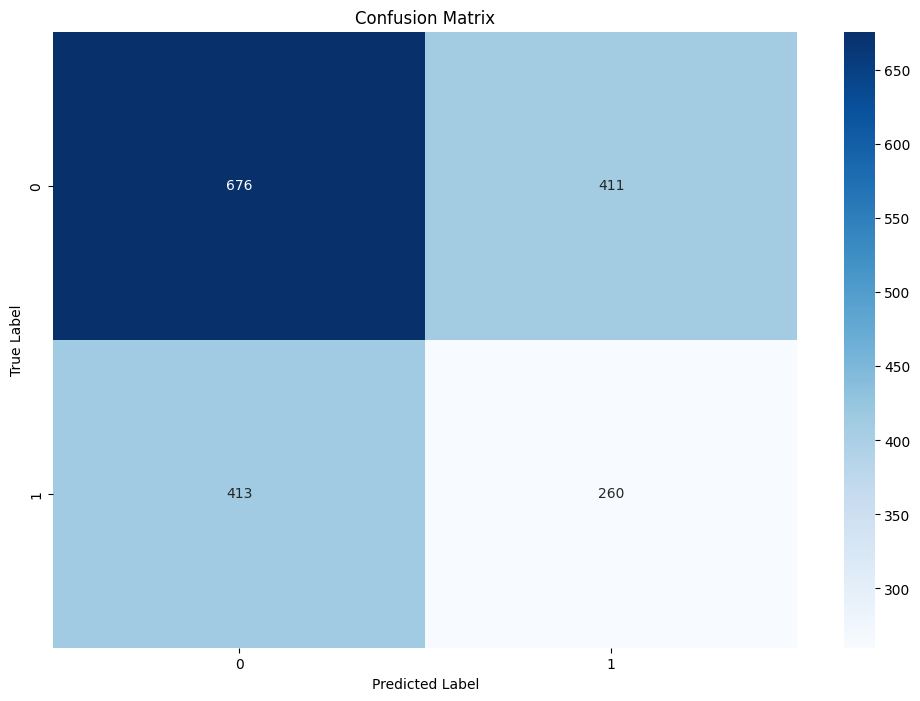

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62      1087
           1       0.39      0.39      0.39       673

    accuracy                           0.53      1760
   macro avg       0.50      0.50      0.50      1760
weighted avg       0.53      0.53      0.53      1760



In [ ]:
predictions = cnn_model.predict(ds_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in ds_test], axis=0)

confusion_mtx = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

classification_rep = classification_report(y_true, y_pred)
print('Classification Report:\n', classification_rep)

 Gere o relatório para cada classe com as métricas precision,recall,f1-scoree o support

In [ ]:
class_report = classification_report(y_true, y_pred, output_dict=True)
df_class_report = pd.DataFrame(class_report).transpose()
df_class_report.to_csv('classification_report.csv')